# Results of this project

In [2]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

from tqdm import tqdm
import sys
sys.path.append("../scripts")

from functions import predict_file

from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score

2024-07-31 18:07:59.563870: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Config

In [3]:
import json

config = json.load(open("../resources/config.json", "r"))

class cfg:
    # random seed
    seed = 42

    # audio clip settings
    sr = config["sampling_rate"] # 22050
    duration = config["duration"] # 15 # the duration of the clips
    
    n_samples = duration*sr
    
    hop_length = config["hop_length"] # 2048 # "stepsize" of the fft for the melspectrograms
    nfft = config["nfft"] # 4096 # windowsize of the fft for the melspectrograms
    n_mels = config["n_mels"] # 128 # number of mel frequency bins
    fmax = sr/2 # maximum frequency in the melspectrograms
    input_dim = (n_mels, int(duration*sr//hop_length + 1))
    
    # training settings
    batch_size = config["batch_size"] # 32
    n_epochs = config["n_epochs"]

    n_classes = 46

### Load dataframes

In [4]:
df_train = pd.read_csv("../../data/dataset_train.csv")
df_test = pd.read_csv("../../data/dataset_test.csv")

df_train.fullfilename = "../" + df_train.fullfilename
df_test.fullfilename = "../" + df_test.fullfilename

In [5]:
unique_species = sorted(df_train['en'].unique())
df_train['gen_sp'] = df_train.apply(lambda row: row['gen'] + " " + row['sp'], axis=1)

# Create a mapping from species to labels
species_to_label = {species: idx for idx, species in enumerate(unique_species)}
label_to_species = {idx: species for idx, species in enumerate(unique_species)}
label_to_gen_sp = df_train.set_index('label')['gen_sp'].to_dict()

### Load trained models and log files

In [6]:
models = []
logs = []
for i in range(5):
    models.append(load_model(f"../models/v3_final_model_{i+1}.keras"))
    logs.append(pd.read_csv(f"../models/v3_final_model_{i+1}_log.csv"))

2024-07-31 18:08:06.801175: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-31 18:08:06.957284: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-31 18:08:06.957886: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-31 18:08:06.959586: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-31 18:08:06.960189: I external/local_xla/xla/stream_executor

## Plot loss, accuracy etc.

In [7]:
colors = ["chartreuse", "fuchsia", "aqua", "yellow", "blueviolet"]
colors = ['#1E90FF', '#FF4500', '#DAA520', '#228B22', '#9932CC']

In [8]:
max_epochs = 0
i_max_epochs = 0
for i in range(5):
    if max_epochs < max(logs[i].epoch):
        max_epochs = max(logs[i].epoch)
        i_max_epochs = i
max_epochs

49

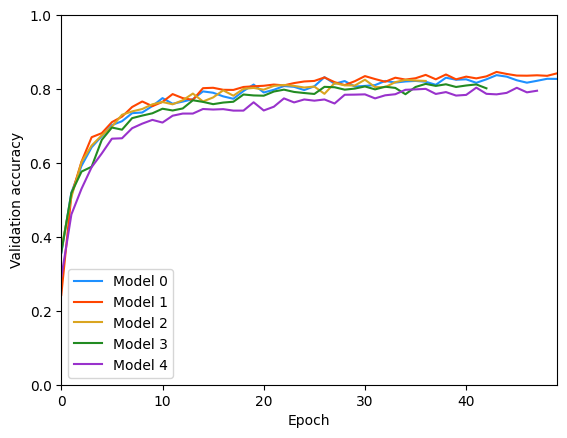

In [9]:
fig, ax = plt.subplots(1,1)
for i in range(5):
    ax.plot(logs[i].epoch, logs[i].val_accuracy, label = f"Model {i}", c = colors[i])

ax.set_xlim(0, max_epochs)
ax.set_ylim(0, 1)
ax.set_ylabel("Validation accuracy")
ax.set_xlabel("Epoch")
ax.legend();

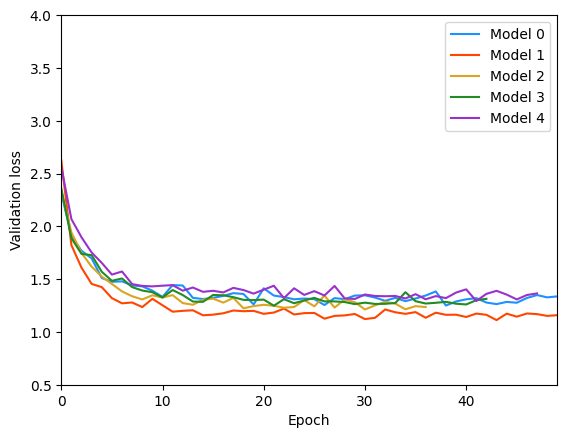

In [10]:
fig, ax = plt.subplots(1,1)
for i in range(5):
    ax.plot(logs[i].epoch, logs[i].val_loss, label = f"Model {i}", c = colors[i])

ax.set_xlim(0, max_epochs)
ax.set_ylim(0.5, 4)
ax.set_ylabel("Validation loss")
ax.set_xlabel("Epoch")
ax.legend();

### Plot example accuracy and loss

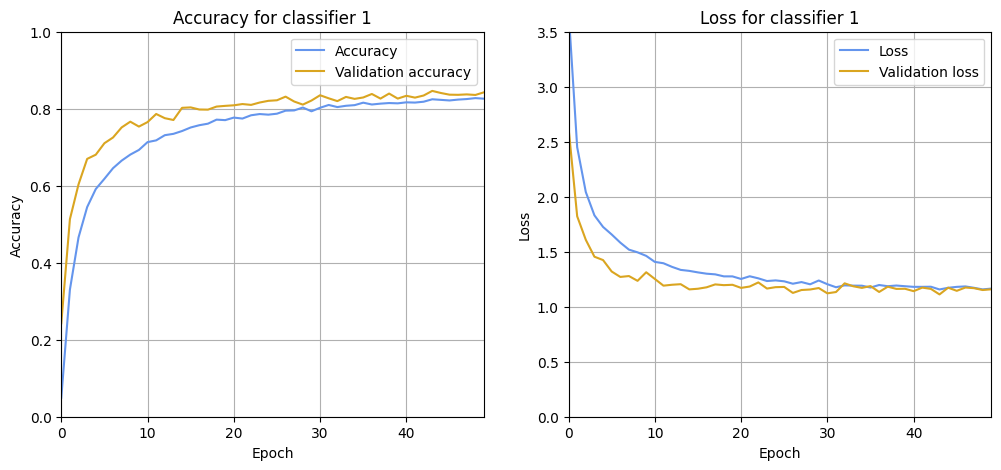

In [16]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
i = 1
ax[0].plot(logs[i].epoch, logs[i].accuracy, label = "Accuracy", c = "cornflowerblue")
ax[0].plot(logs[i].epoch, logs[i].val_accuracy, label = "Validation accuracy", c = "goldenrod")

ax[0].set_xlim(0, max_epochs)
ax[0].set_ylim(0, 1)
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Epoch")
ax[0].grid()
ax[0].set_title(f"Accuracy for classifier {i}")
ax[0].legend();

ax[1].plot(logs[i].epoch, logs[i].loss, label = "Loss", c = "cornflowerblue")
ax[1].plot(logs[i].epoch, logs[i].val_loss, label = "Validation loss", c = "goldenrod")

ax[1].set_xlim(0, max_epochs)
ax[1].set_ylim(0, 3.5)
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")
ax[1].grid()
ax[1].set_title(f"Loss for classifier {i}")
ax[1].legend();

### Mean values of acc vs val_acc, loss vs val_loss

In [17]:
mean_acc = np.zeros(shape = (5, max_epochs+1), dtype = float)
mean_val_acc = np.zeros(shape = (5, max_epochs+1), dtype = float)
mean_loss = np.zeros(shape = (5, max_epochs+1), dtype = float)
mean_val_loss = np.zeros(shape = (5, max_epochs+1), dtype = float)
for i in range(5):
    mean_acc[i, :] = logs[i_max_epochs].accuracy
    mean_val_acc[i, :] = logs[i_max_epochs].val_accuracy
    mean_loss[i, :] = logs[i_max_epochs].loss
    mean_val_loss[i, :] = logs[i_max_epochs].val_loss
    mean_acc[i, :max(logs[i].epoch)+1] = logs[i].accuracy
    mean_val_acc[i, :max(logs[i].epoch)+1] = logs[i].val_accuracy
    mean_loss[i, :max(logs[i].epoch)+1] = logs[i].loss
    mean_val_loss[i, :max(logs[i].epoch)+1] = logs[i].val_loss
mean_acc = np.mean(mean_acc, axis = 0)
mean_val_acc = np.mean(mean_val_acc, axis = 0)
mean_loss = np.mean(mean_loss, axis = 0)
mean_val_loss = np.mean(mean_val_loss, axis = 0)

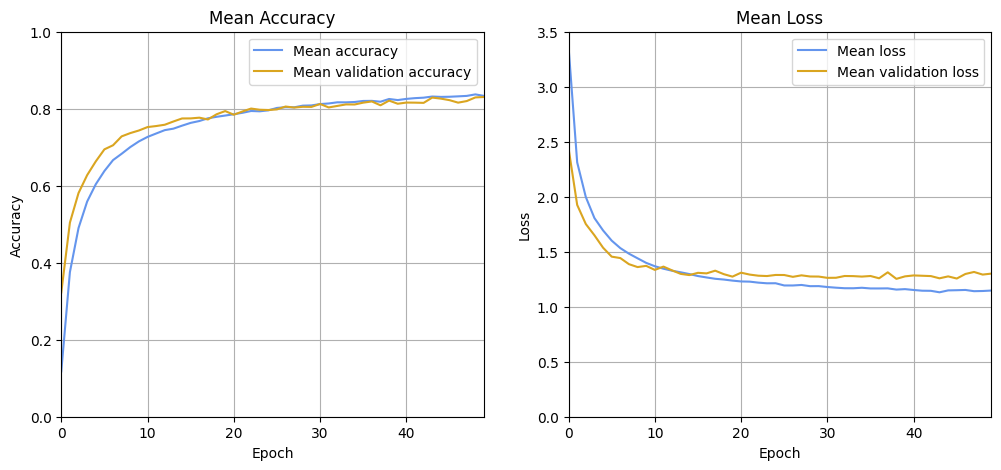

In [18]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
ax[0].plot(range(max_epochs+1), mean_acc, label = "Mean accuracy", c = "cornflowerblue")
ax[0].plot(range(max_epochs+1), mean_val_acc, label = "Mean validation accuracy", c = "goldenrod")

ax[0].set_xlim(0, max_epochs)
ax[0].set_ylim(0, 1)
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Epoch")
ax[0].grid()
ax[0].set_title("Mean Accuracy")
ax[0].legend();

ax[1].plot(range(max_epochs+1), mean_loss, label = "Mean loss", c = "cornflowerblue")
ax[1].plot(range(max_epochs+1), mean_val_loss, label = "Mean validation loss", c = "goldenrod")

ax[1].set_xlim(0, max_epochs)
ax[1].set_ylim(0, 3.5)
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")
ax[1].grid()
ax[1].set_title("Mean Loss")
ax[1].legend();

plt.savefig("../../plots/mean_metrics_v3.pdf")

## Make predictions

In [13]:
#preds_train = np.zeros(shape = (len(df_train), cfg.n_classes, 5), dtype = float)
#for i in range(5):
#    for ID in tqdm(range(len(df_train))):
#        preds_train[ID, :, i] = predict_file(df_train, ID, models[i], cfg=cfg)

  0%|                                                                                         | 0/13875 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1722350519.913044     227 service.cc:145] XLA service 0x7f9380003bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722350519.913123     227 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2024-07-30 16:41:59.966206: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-30 16:42:00.132167: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1722350522.411540     227 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|████████████████████████

In [19]:
## Save the array to a .npy file
#np.save('../results/v3_preds_train.npy', preds_train)

# Load the array back from the .npy file
preds_train = np.load('../results/v3_preds_train.npy')

### Use mean for predictions

In [20]:
preds_train_mean = np.mean(preds_train, axis = -1)

In [21]:
preds_class_train = np.argmax(preds_train_mean, axis=1)
one_hot_pred_train = np.zeros_like(preds_train_mean)
one_hot_pred_train[np.arange(len(preds_class_train)), preds_class_train] = 1

true_labels_train = df_train.label

In [22]:
print(f"Accuracy on training data: {accuracy_score(df_train.label, preds_class_train)*100:.4f} %")
print(f"Balanced accuracy score on training data: {balanced_accuracy_score(df_train.label, preds_class_train)*100:.4f} %")

Accuracy on training data: 93.8811 %
Balanced accuracy score on training data: 93.8243 %


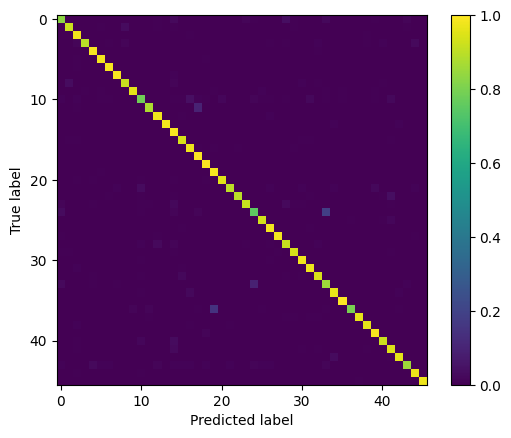

In [23]:
cm = confusion_matrix(df_train.label, preds_class_train, normalize = "true")

plt.imshow(cm, interpolation='nearest', cmap="viridis")
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label');

### Use best estimator for predictions

In [24]:
i_best = 0
acc_best = 0
for i in range(5):
    if max(logs[i].val_accuracy) > acc_best:
        acc_best = max(logs[i].val_accuracy)
        i_best = i
i_best

1

In [25]:
preds_train_best = preds_train[:,:, i_best]

Accuracy on training data: 91.7982 %
Balanced accuracy score on training data: 91.1089 %


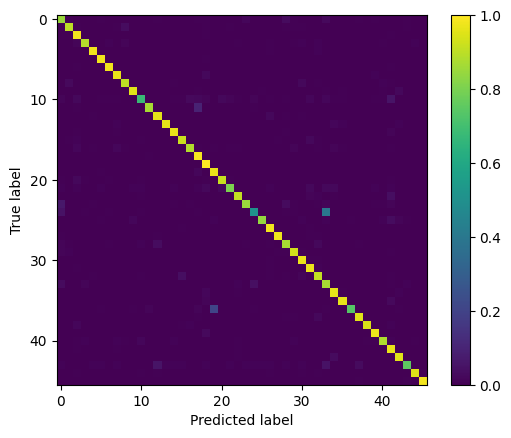

In [26]:
preds_class_train = np.argmax(preds_train_best, axis=1)
print(f"Accuracy on training data: {accuracy_score(df_train.label, preds_class_train)*100:.4f} %")
print(f"Balanced accuracy score on training data: {balanced_accuracy_score(df_train.label, preds_class_train)*100:.4f} %")
cm = confusion_matrix(df_train.label, preds_class_train, normalize = "true")

plt.imshow(cm, interpolation='nearest', cmap="viridis")
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label');

### Use voting

In [27]:
preds_train_vote = np.argmax(preds_train, axis=1)

In [28]:
preds_train_vote

array([[ 2,  2,  2,  2,  2],
       [ 2,  2,  2,  2,  2],
       [ 2,  2,  2,  2,  2],
       ...,
       [13, 13, 13, 13, 13],
       [13, 13, 13, 13, 13],
       [13, 13, 13, 13, 13]])

In [29]:
from scipy.stats import mode
preds_class_train = mode(preds_train_vote, axis = 1).mode

Accuracy on training data: 93.5207 %
Balanced accuracy score on training data: 93.3558 %


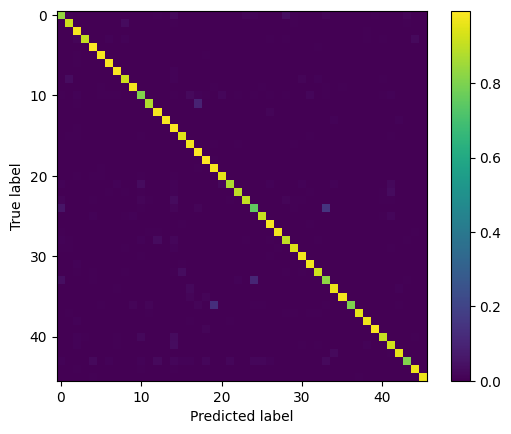

In [30]:
print(f"Accuracy on training data: {accuracy_score(df_train.label, preds_class_train)*100:.4f} %")
print(f"Balanced accuracy score on training data: {balanced_accuracy_score(df_train.label, preds_class_train)*100:.4f} %")
cm = confusion_matrix(df_train.label, preds_class_train, normalize = "true")

plt.imshow(cm, interpolation='nearest', cmap="viridis")
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label');

## Predictions on test data

In [14]:
#preds_test = np.zeros(shape = (len(df_test), cfg.n_classes, 5), dtype = float)
#for i in range(5):
#    for ID in tqdm(range(len(df_test))):
#        preds_test[ID, :, i] = predict_file(df_test, ID, models[i], cfg=cfg)

  0%|                                                                                          | 0/3506 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1722288972.611944    5909 service.cc:145] XLA service 0x150b4000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722288972.612026    5909 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2024-07-29 23:36:12.659921: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-29 23:36:12.783435: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1722288974.418610    5909 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|████████████████████████████

In [31]:
# Save the array to a .npy file
#np.save('../results/v3_preds_test.npy', preds_test)

## Load the array back from the .npy file
preds_test = np.load('../results/v3_preds_test.npy')

In [32]:
preds_test_mean = np.mean(preds_test, axis = -1)
preds_class_test = np.argmax(preds_test_mean, axis=1)

Base score: 3.3371 %
Accuracy on test data: 90.0171 %
Balanced accuracy score on test data: 88.8519 %


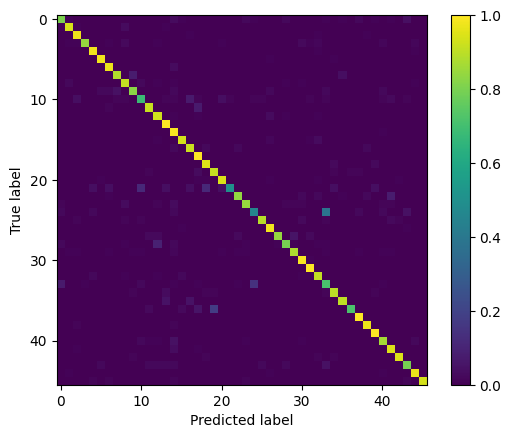

In [33]:
base_score = max(df_test.groupby('label')["label"].count())/len(df_test)
print(f"Base score: {base_score*100:.4f} %")
print(f"Accuracy on test data: {accuracy_score(df_test.label, preds_class_test)*100:.4f} %")
print(f"Balanced accuracy score on test data: {balanced_accuracy_score(df_test.label, preds_class_test)*100:.4f} %")
cm_test = confusion_matrix(df_test.label, preds_class_test, normalize = "true")

plt.imshow(cm_test, interpolation='nearest', cmap="viridis")
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label');

plt.savefig("../../plots/cm.pdf")

In [34]:
trues_test = to_categorical(df_test.label)
trues_train = to_categorical(df_train.label)

In [35]:
def plot_probability_dist(classnr, preds_test, trues_test, preds_train, trues_train):
    fig = plt.figure(figsize = (5, 4))
    _, bins, _ = plt.hist(preds_test[:, classnr][trues_test[:, classnr] == 1], bins = 15, color = "chartreuse", range = [0, 1], 
                      density = True, label = f"Target class, test data", alpha = .8)
    plt.hist(preds_test[:, classnr][trues_test[:, classnr] != 1], bins = bins, color = "fuchsia", 
             density = True, label = f"Other classes, test data", alpha = .6)
    plt.hist(preds_train[:, classnr][trues_train[:, classnr] == 1], bins = bins, color = "forestgreen", range = [0, 1], 
             density = True, label = f"Target class, training data", histtype = "step", lw = 2)
    plt.hist(preds_train[:, classnr][trues_train[:, classnr] != 1], bins = bins, color = "slateblue", 
             density = True, lw = 2, label = f"Other classes, training data", histtype = "step")
    plt.xlabel(f"Probability of belonging to class {classnr}")
    plt.ylabel("Counts [a.u.]")
    plt.title(f"Probability distribution for true {classnr}", fontsize = 12)
    plt.legend()
    plt.tight_layout()
    return fig

/tmp/ipykernel_164/4099462361.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize = (5, 4))


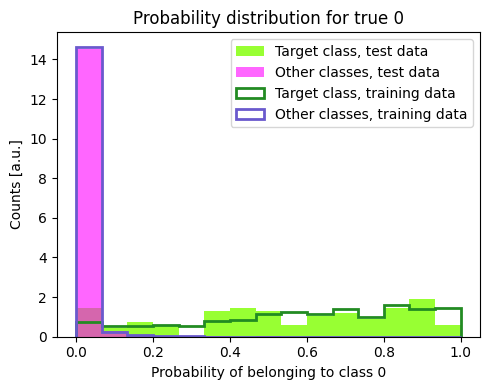

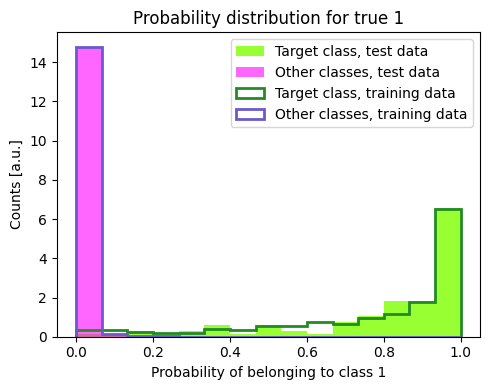

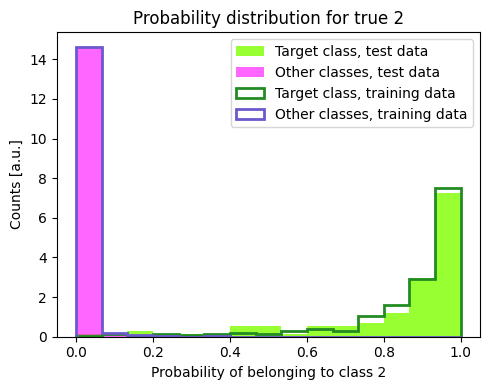

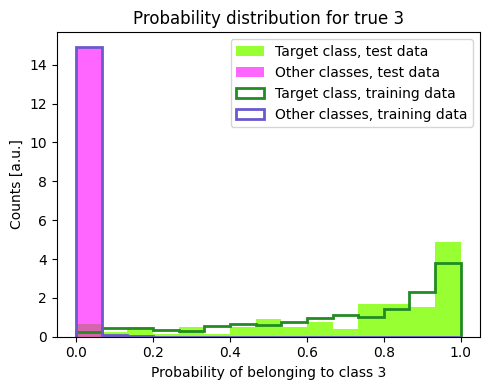

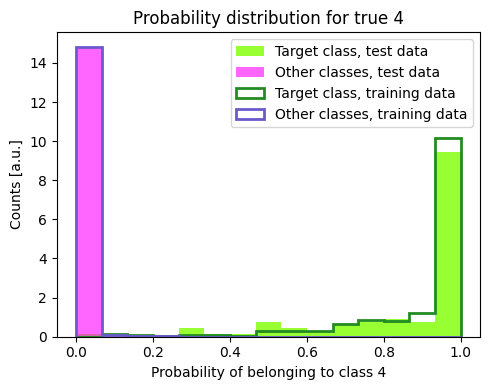

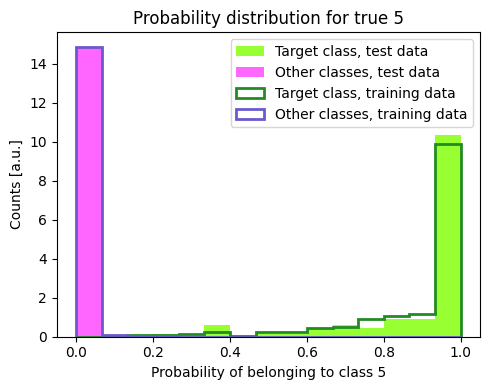

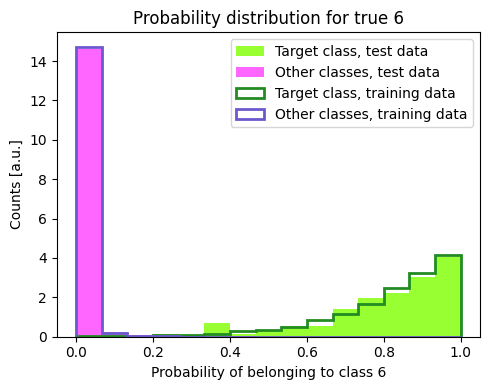

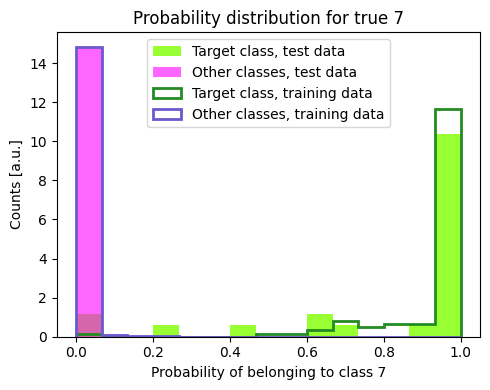

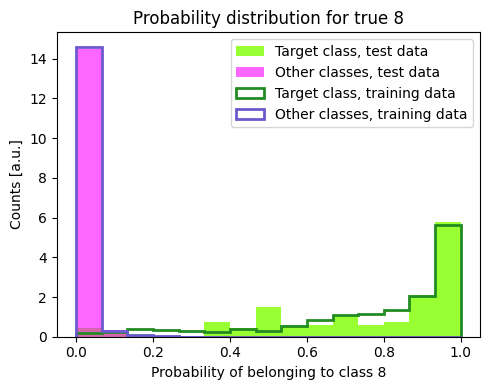

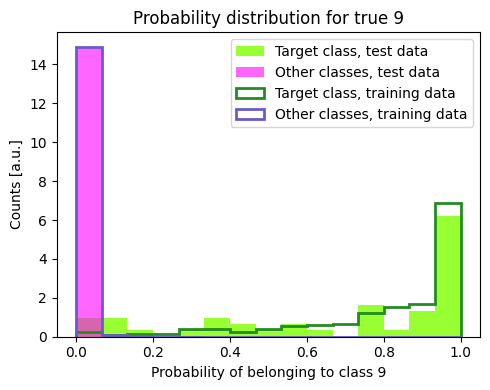

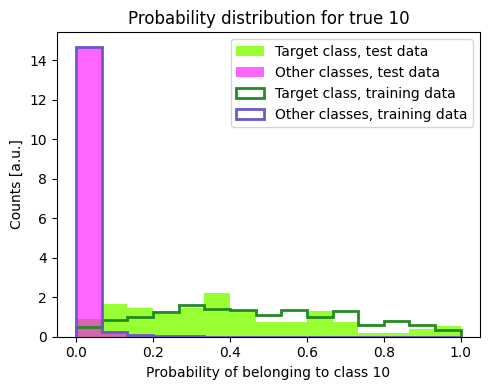

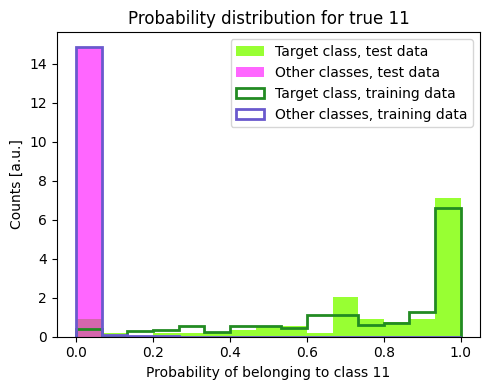

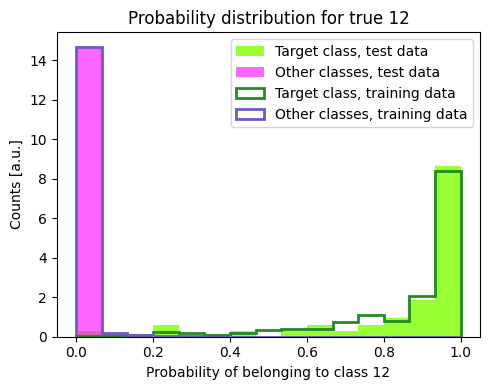

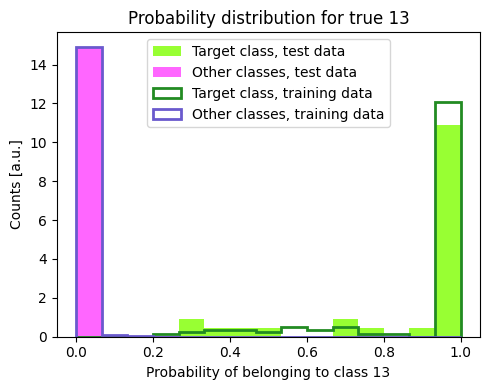

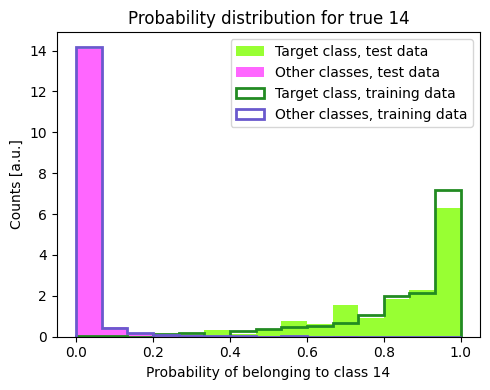

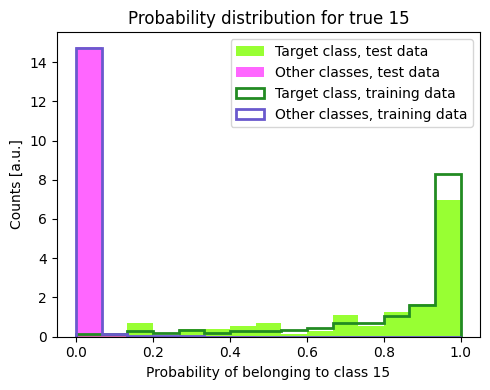

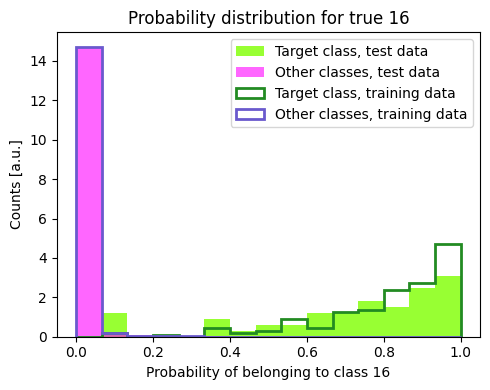

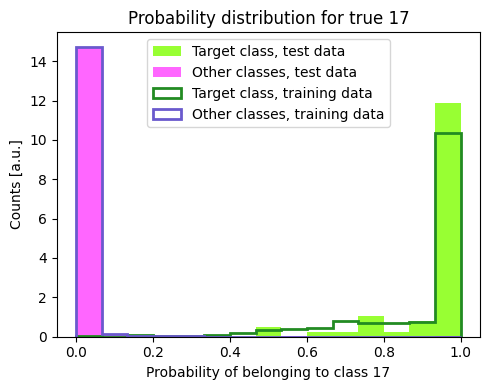

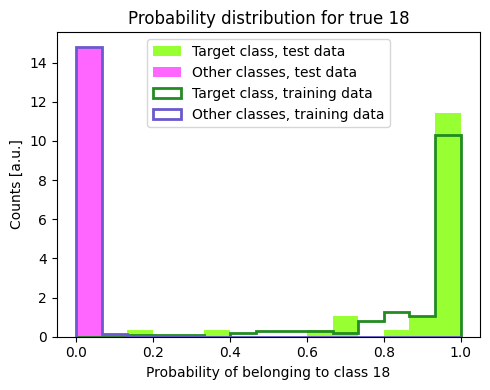

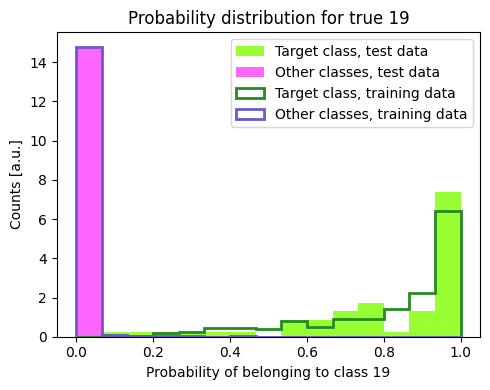

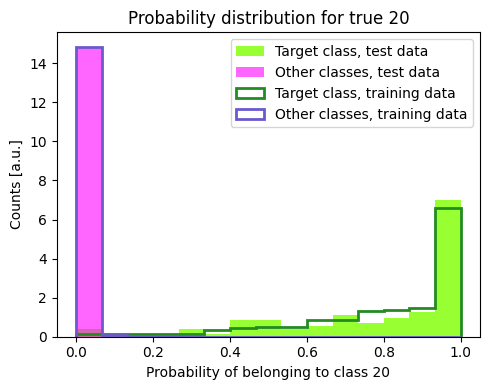

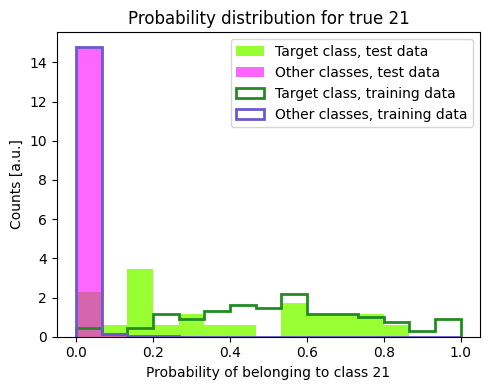

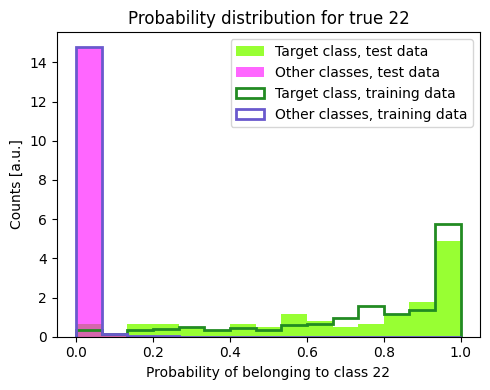

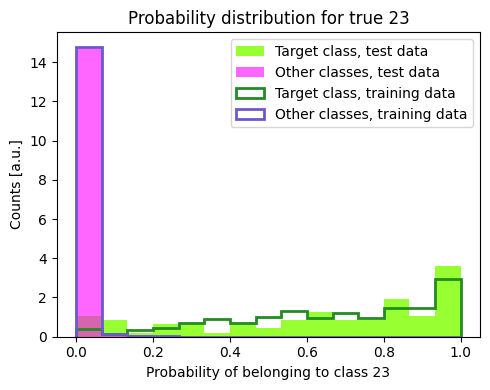

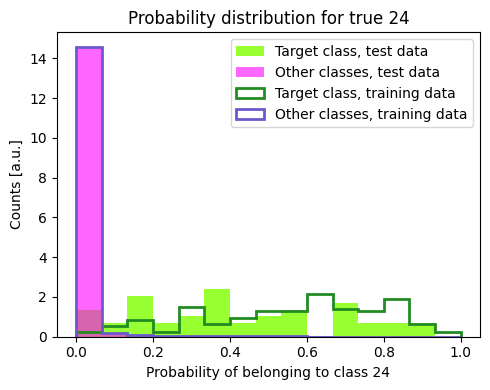

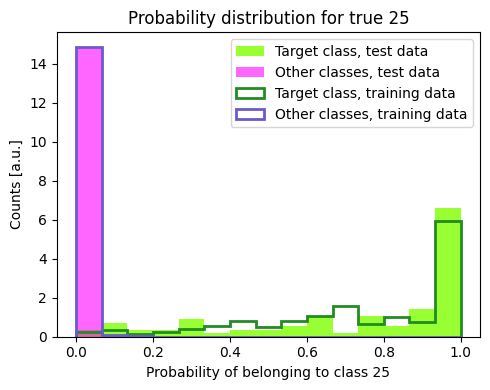

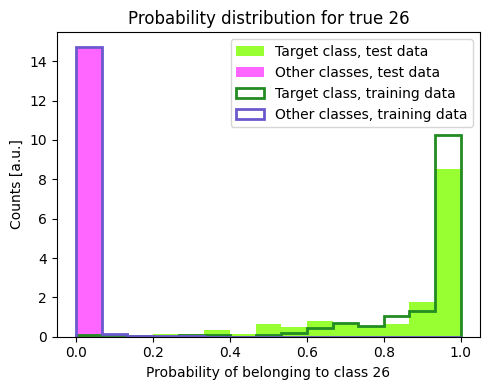

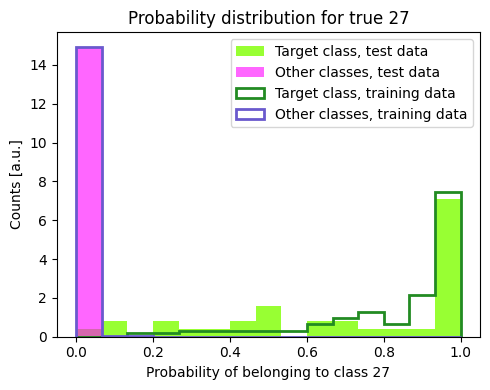

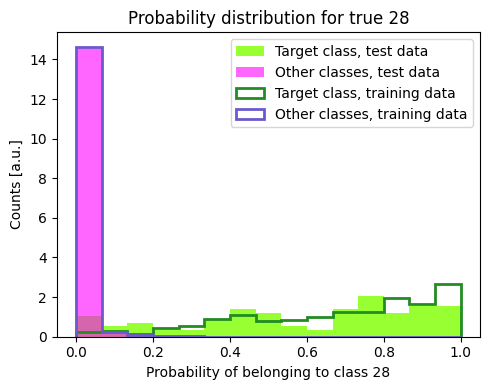

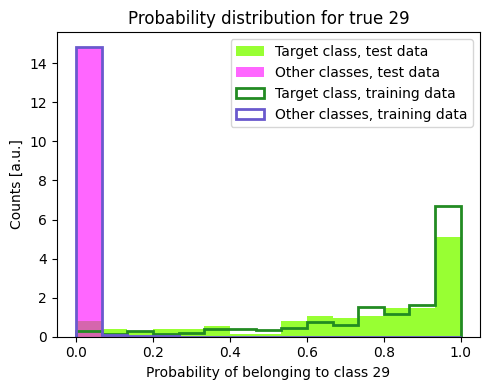

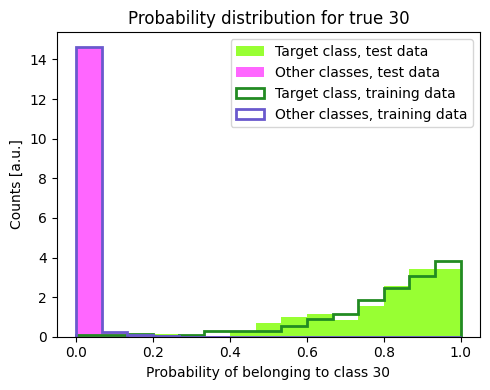

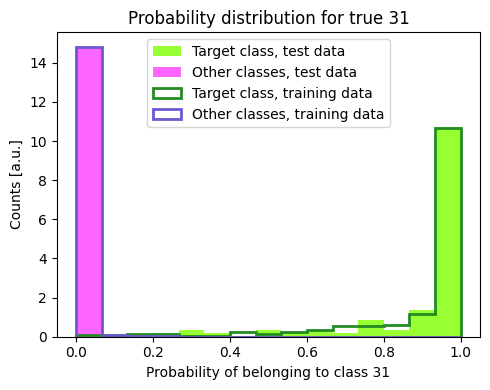

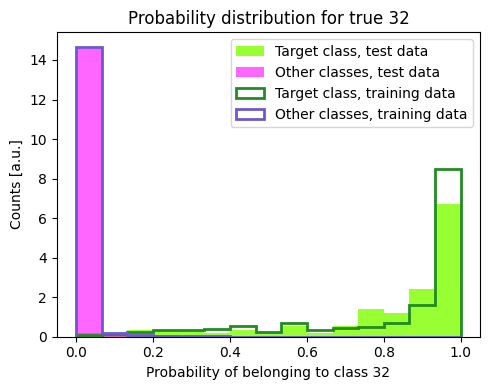

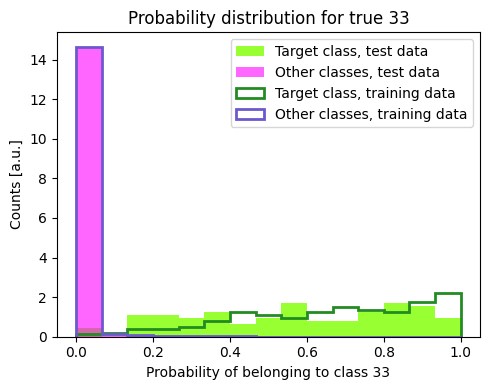

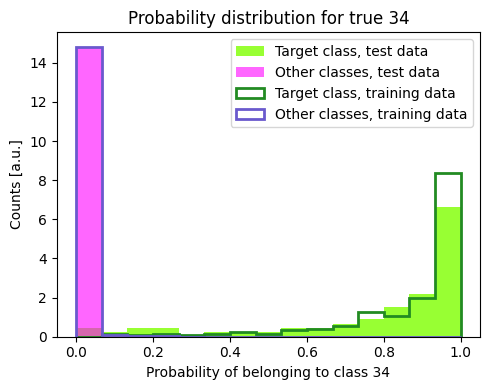

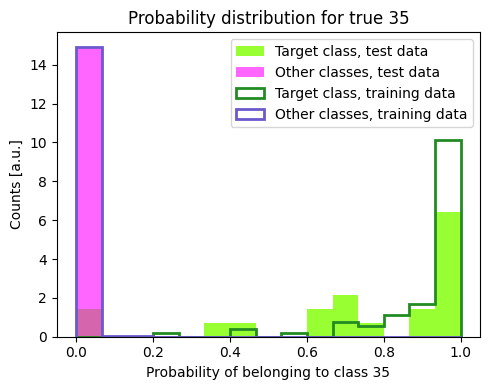

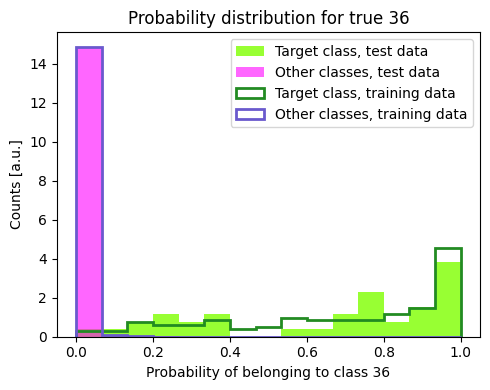

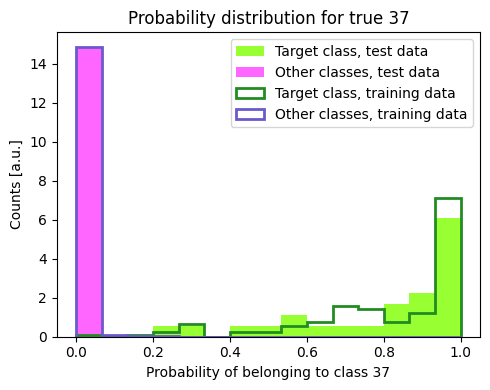

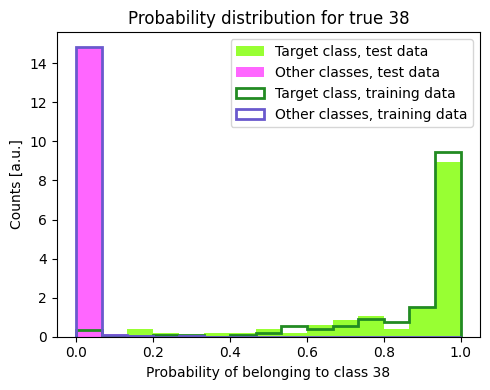

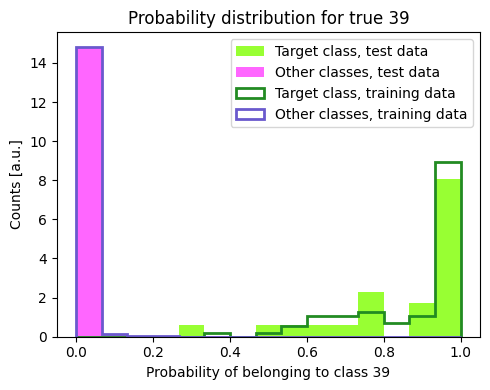

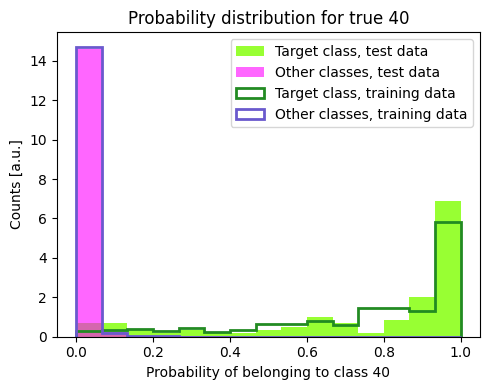

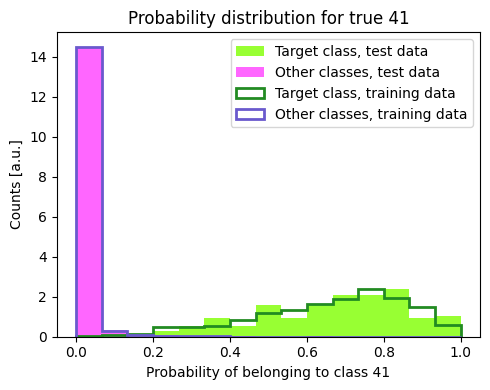

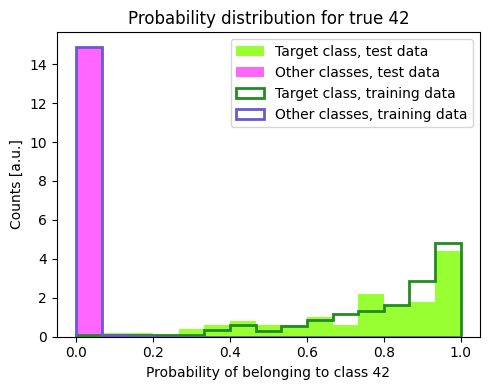

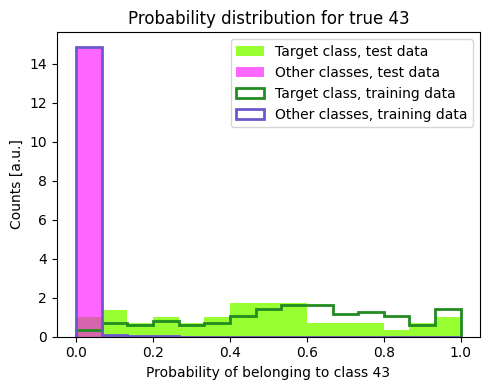

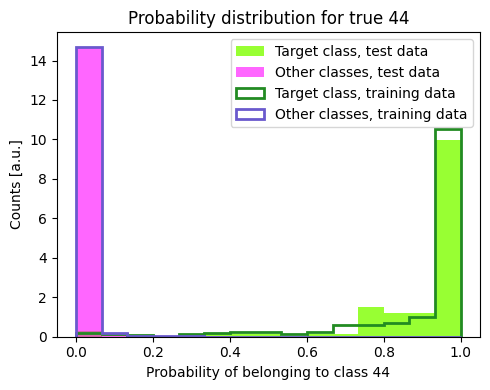

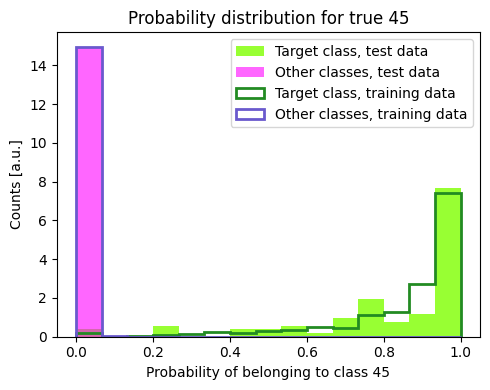

In [36]:
import os
if not os.path.exists("../../plots/probability_dist/"):
    os.makedirs("../../plots/probability_dist/")

for i in range(46):
    fig = plot_probability_dist(i, preds_test_mean, trues_test, preds_train_mean, trues_train)
    fig.savefig(f"../../plots/probability_dist/class_{i}.pdf")

## Wrong classifications

In [37]:
n_files = df_train.groupby("label").label.count()

In [38]:
average_length = df_train.groupby("label").length_seconds.mean()

In [39]:
print("Worst classified classes:")
print("********************")
worst_classes = np.argsort(np.diag(cm_test))

for i in range(15):
    label = worst_classes[i]
    confused_with = np.argsort(cm_test[label, :])[-2]
    print(f"{label},  {label_to_species[label]}:\t {np.diag(cm_test)[label]*100:.2f} % accuracy, {n_files[i]} files"
          f"\nConfused with:\n{confused_with}, {label_to_species[confused_with]}: \t {cm_test[label, confused_with]*100:.2f} %, {n_files[confused_with]} files")
    print("********************")

Worst classified classes:
********************
24,  Eurasian Tree Sparrow:	 45.45 % accuracy, 398 files
Confused with:
33, House Sparrow: 	 38.64 %, 361 files
********************
21,  Eurasian Jay:	 50.00 % accuracy, 402 files
Confused with:
18, Eurasian Curlew: 	 11.54 %, 154 files
********************
10,  Common Starling:	 68.29 % accuracy, 388 files
Confused with:
16, Eurasian Bullfinch: 	 7.32 %, 165 files
********************
33,  House Sparrow:	 71.13 % accuracy, 383 files
Confused with:
24, Eurasian Tree Sparrow: 	 14.43 %, 141 files
********************
36,  Long-eared Owl:	 71.79 % accuracy, 403 files
Confused with:
19, Eurasian Eagle-Owl: 	 17.95 %, 265 files
********************
28,  European Goldfinch:	 79.31 % accuracy, 403 files
Confused with:
12, Dunnock: 	 9.20 %, 403 files
********************
43,  White Wagtail:	 79.55 % accuracy, 389 files
Confused with:
33, House Sparrow: 	 4.55 %, 361 files
********************
0,  Barn Swallow:	 80.39 % accuracy, 94 files
Confus

In [40]:
errors = preds_class_test != df_test.label

In [41]:
preds_gen = [label_to_gen_sp[label] for label in preds_class_test]
preds_wrong = np.array(preds_gen)[errors]

In [42]:
df_wrong = df_test[errors]
df_wrong.reset_index(drop = True, inplace = True)
x = []
for i, row in df_wrong.iterrows():
    if preds_wrong[i] in df_wrong.loc[i, 'also']:
        x.append([preds_wrong[i],  df_wrong.loc[i, 'also']])

In [43]:
print(f"At least {len(x)/len(df_wrong)*100:.2f} % of wrongly classified samples have the predicted bird in the recording.")

At least 5.14 % of wrongly classified samples have the predicted bird in the recording.


In [44]:
preds_second = np.argsort(preds_test_mean, axis = 1)[:, -2]

true_second = preds_second[errors] == df_test.label[errors]
print(f"For {len(preds_second[errors][true_second])/len(preds_wrong)*100:.2f} % of the wrongly classified labels, the second prediceted label is the true label.")

For 57.43 % of the wrongly classified labels, the second prediceted label is the true label.


### Top errors

In [45]:
top_errors = np.argsort(np.max(preds_test_mean[errors],axis = 1) - np.diagonal(np.take(preds_test_mean[errors], df_test.label[errors], axis=1)))[::-1]

In [46]:
import h5py
def load_spectrogram_slice(df, ID, start_row = 0, end_row =None, start_col = 0, end_col = None):
    name = df.spectrogram.iloc[ID]
    hdf5_path = os.path.dirname(df.fullfilename.iloc[ID]) + "/spectrograms.h5"
    with h5py.File(hdf5_path, 'r') as f:
        spectrogram_slice = f[name][start_row:end_row, start_col:end_col]
    return spectrogram_slice

In [66]:
from IPython.display import Audio

ID = top_errors[3]
audio, sr = librosa.load(df_wrong.fullfilename.iloc[ID], sr = cfg.sr)
print(df_wrong.label.iloc[ID])
Audio(audio, rate = sr, autoplay = True)

21


In [73]:
df_wrong.iloc[top_errors[:4]].lic

228    //creativecommons.org/licenses/by-nc-nd/4.0/
44     //creativecommons.org/licenses/by-nc-sa/4.0/
17     //creativecommons.org/licenses/by-nc-sa/4.0/
208    //creativecommons.org/licenses/by-nc-nd/4.0/
Name: lic, dtype: object

In [68]:
label_to_species[21]

'Eurasian Jay'

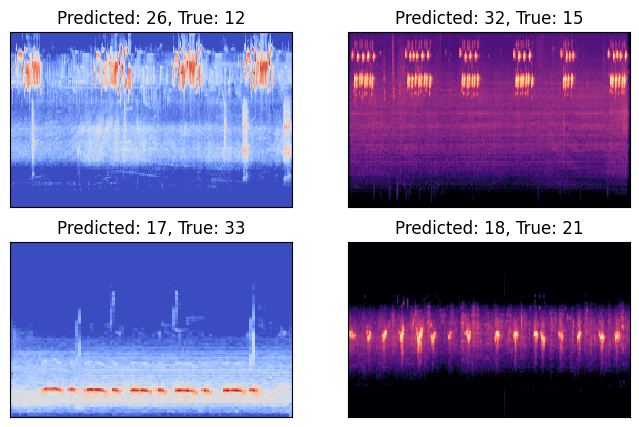

In [56]:
fig, ax = plt.subplots(2, 2, figsize = (8, 5))
for i in range(4):
    spec = load_spectrogram_slice(df_wrong, top_errors[i])
    librosa.display.specshow(spec, sr=cfg.sr, hop_length=cfg.hop_length, ax = ax[i//2, i%2]);
    ax[i//2, i%2].set_title(f"Predicted: {preds_class_test[errors][top_errors[i]]}, True: {df_wrong.iloc[top_errors[i]].label}")

fig.save

In [51]:
### Das unten links ist straight up einfach flasch gelabeled

### Most importantly: Can it identify birds I recorded myself?

In [52]:
from functions import compute_spec, predict_spec
files = ["Vogel_Terasse.mp3", "Terasse1.mp3", "Terasse2.mp3", "Terasse3.mp3"]
for i in range(len(files)):
    files[i] = "../../data/own_recordings/" + files[i]

specs = []
for file in files:
    specs.append(compute_spec(file, cfg = cfg))

preds = np.zeros(shape = (len(files), cfg.n_classes, 5), dtype = float)
for i in range(5):
    for j in range(len(specs)):
        preds[j, :, i] = predict_spec(specs[j], models[i], cfg = cfg)

I0000 00:00:1722442206.183959     255 service.cc:145] XLA service 0x7fbb38004810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722442206.184015     255 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2024-07-31 18:10:06.237370: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-31 18:10:06.391852: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1722442208.046347     255 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


In [53]:
preds_mean = np.mean(preds, axis = -1)

In [54]:
np.argmax(preds_mean, axis = 1)

array([ 4, 11, 37, 37])

In [55]:
label_to_species[37]

'Meadow Pipit'